<a href="https://colab.research.google.com/github/Derek2124/Stock-Price-Predictor-LSTM-Model-/blob/main/Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy as dc
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [ ]:
#Prepare data
df = pd.read_csv('UBER.csv')
df = df[['Date', 'Adj Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True);

#Get Stock Returns
prices = df['Adj Close'].to_numpy()
returns = np.diff(prices) / prices[:-1]
df['Stock Returns'] = np.nan
df['Stock Returns'].iloc[1:] = returns
df = df.drop(['Adj Close'], axis = 1)

In [ ]:
#Prepare data for LSTM
def prepare_df_LSTM(df, n_days):
  #Innit df
  df = dc(df)
  #Create columns for LSTM data (one week)
  for i in range(1, n_days+1):
    df['Target (T - {})'.format(i)] = df['Stock Returns'].shift(i)

  #Remove na values
  df.dropna(inplace = True)

  return df

n_days = 7
LSTM_df = prepare_df_LSTM(df, n_days)

#Switch into NumPy Array
LSTM_df = LSTM_df.to_numpy()

In [ ]:
#Scale the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(LSTM_df)
gmm = GaussianMixture(n_components=7, random_state=0)
gmm.fit(data_normalized);

In [ ]:
#Split Train and Test Data
X = LSTM_df[:,1:]
Y = LSTM_df[:,0]

Split = int(len(X) * 0.85)

X_train = X[:Split]
X_test = X[Split:]
Y_train = Y[:Split]
Y_test = Y[Split:]

In [ ]:
#Change to PyTorch Tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
Y_train = torch.tensor(Y_train).float()
Y_test = torch.tensor(Y_test).float()

In [ ]:
#LSTM Model
class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTM_Model, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Convert DataFrame to tensor and ensure it's correctly shaped
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x.values, dtype=torch.float32)
        x = x.unsqueeze(0)  # Add a batch dimension if missing

        # Move tensor to appropriate device
        device = x.device
        x = x.to(device)

        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
#Test Model
model = LSTM_Model(input_dim=7, hidden_dim=32, output_dim=1, num_layers=1)

In [ ]:
#Train Model
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
epochs = 100

#Gradient Descent
for epoch in range(epochs):
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #Print the loss every few epochs
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0126
Epoch [11/100], Loss: 0.0124
Epoch [21/100], Loss: 0.0122
Epoch [31/100], Loss: 0.0120
Epoch [41/100], Loss: 0.0118
Epoch [51/100], Loss: 0.0116
Epoch [61/100], Loss: 0.0114
Epoch [71/100], Loss: 0.0112
Epoch [81/100], Loss: 0.0110
Epoch [91/100], Loss: 0.0108


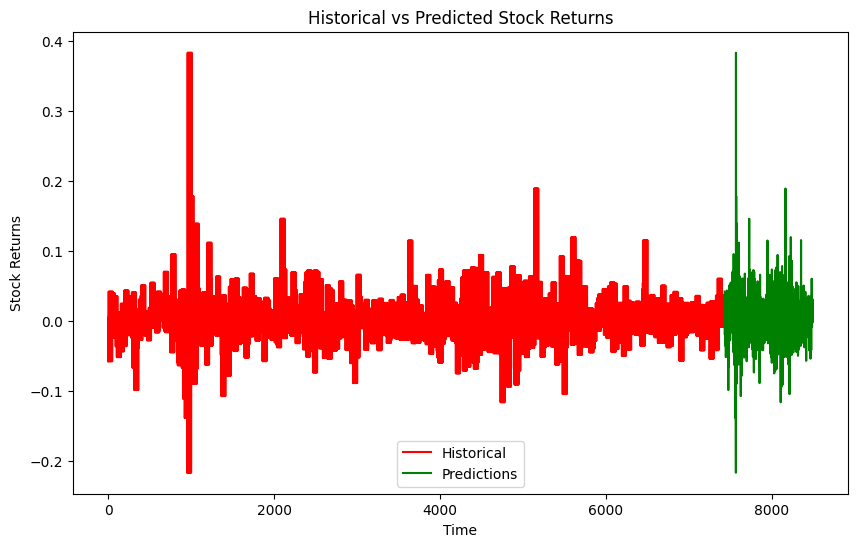

In [ ]:
#Prep for Graph
predict = pd.DataFrame((Y_train.detach().numpy().reshape(-1, 1)))
original = pd.DataFrame((X_train.detach().numpy().reshape(-1, 1)))
#Graph the data
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
xa = list(range(len(original)))
ax.plot(xa, original, color='red', label='Historical')
xb = list(range(len(original), len(original) + len(predict)))
ax.plot(xb, predict, color='green', label='Predictions')
ax.set_xlabel('Time')
ax.set_ylabel('Stock Returns')
ax.set_title('Historical vs Predicted Stock Returns')
ax.legend()
plt.show()
